In [1]:
# Instala librerías necesarias
!pip install torch


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## A - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,3,3,1]

### I - Grilla de 5 x 5:

PINN:

Epoch 0, Loss: 0.4520280361175537
Epoch 100, Loss: 0.19503949582576752
Epoch 200, Loss: 0.15657885372638702
Epoch 300, Loss: 0.12666314840316772
Epoch 400, Loss: 0.09578699618577957
Epoch 500, Loss: 0.08816084265708923
Epoch 600, Loss: 0.08455505222082138
Epoch 700, Loss: 0.08112728595733643
Epoch 800, Loss: 0.07760782539844513
Epoch 900, Loss: 0.07421998679637909
Epoch 1000, Loss: 0.07147232443094254
Epoch 1100, Loss: 0.0696578100323677
Epoch 1200, Loss: 0.06875085085630417
Epoch 1300, Loss: 0.06839330494403839
Epoch 1400, Loss: 0.06823699921369553
Epoch 1500, Loss: 0.06814078241586685
Epoch 1600, Loss: 0.06806761026382446
Epoch 1700, Loss: 0.06800627708435059
Epoch 1800, Loss: 0.06795100122690201
Epoch 1900, Loss: 0.06789698451757431
Epoch 2000, Loss: 0.06783846765756607
Epoch 2100, Loss: 0.06776600331068039
Epoch 2200, Loss: 0.06765997409820557
Epoch 2300, Loss: 0.06747101992368698
Epoch 2400, Loss: 0.0670449510216713
Epoch 2500, Loss: 0.06575148552656174
Epoch 2600, Loss: 0.0601163

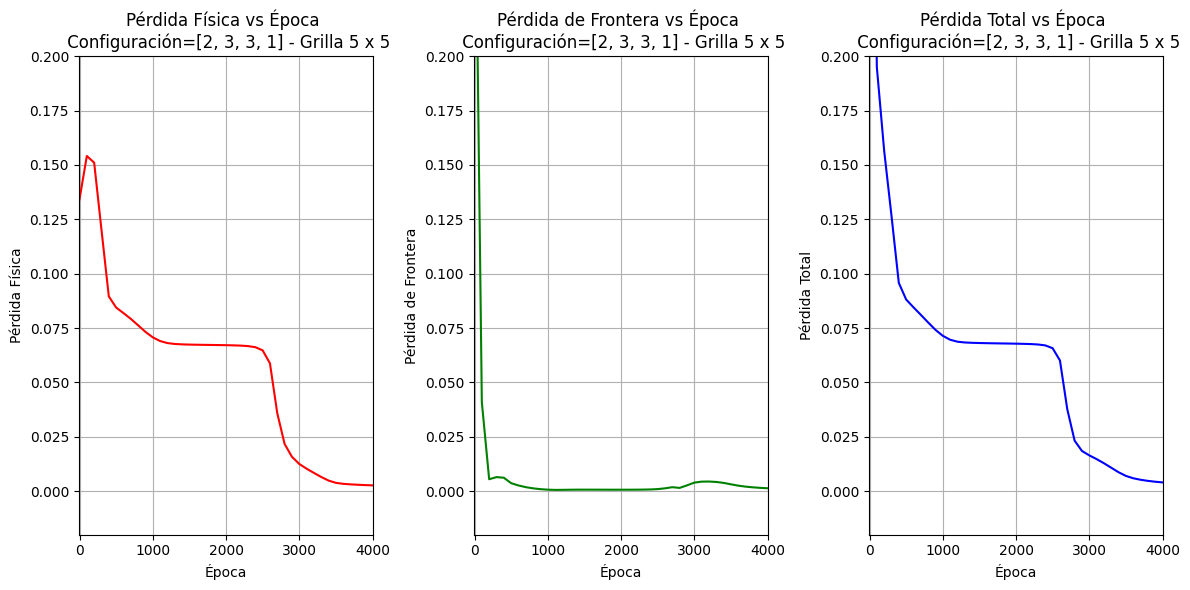

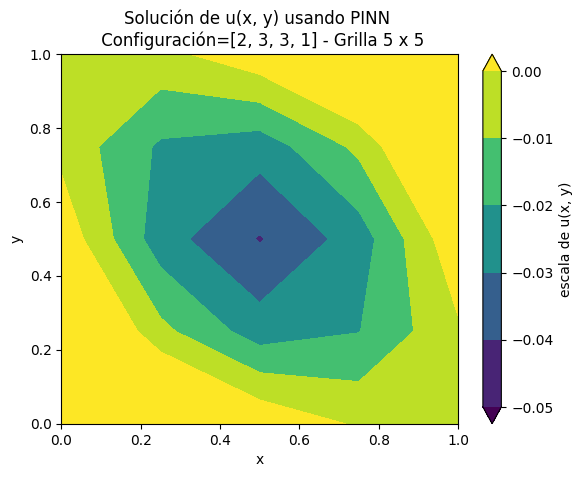

In [43]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_5x5, y_5x5, u_pred_5x5, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

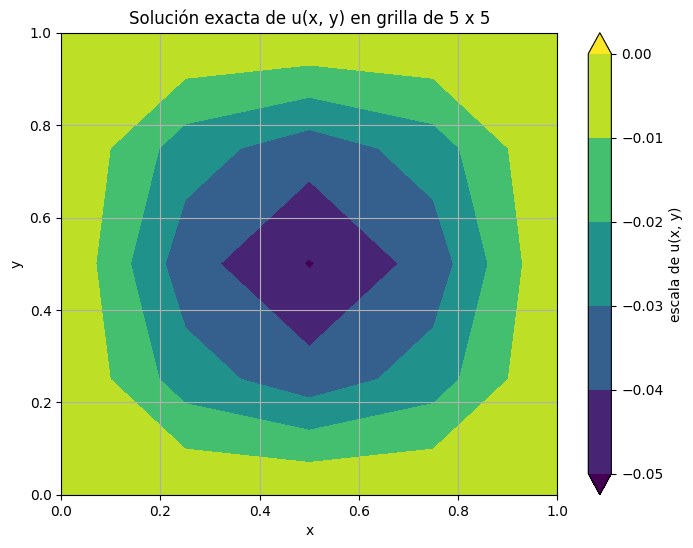

In [44]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_5x5, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

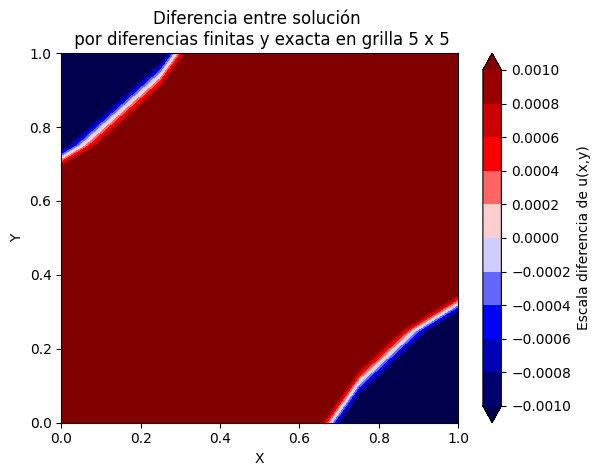

In [45]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_5x5, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.3021971583366394
Epoch 100, Loss: 0.15360891819000244
Epoch 200, Loss: 0.10760547965765
Epoch 300, Loss: 0.08950023353099823
Epoch 400, Loss: 0.08392903208732605
Epoch 500, Loss: 0.07988625764846802
Epoch 600, Loss: 0.07531740516424179
Epoch 700, Loss: 0.07062185555696487
Epoch 800, Loss: 0.06668757647275925
Epoch 900, Loss: 0.06322886049747467
Epoch 1000, Loss: 0.05857202410697937
Epoch 1100, Loss: 0.05304323136806488
Epoch 1200, Loss: 0.048718370497226715
Epoch 1300, Loss: 0.04388473927974701
Epoch 1400, Loss: 0.038363534957170486
Epoch 1500, Loss: 0.03262122720479965
Epoch 1600, Loss: 0.02729099988937378
Epoch 1700, Loss: 0.02315954491496086
Epoch 1800, Loss: 0.020639093592762947
Epoch 1900, Loss: 0.01911984011530876
Epoch 2000, Loss: 0.01779945008456707
Epoch 2100, Loss: 0.01614520139992237
Epoch 2200, Loss: 0.013810229487717152
Epoch 2300, Loss: 0.010817380622029305
Epoch 2400, Loss: 0.007871546782553196
Epoch 2500, Loss: 0.005675580818206072
Epoch 2600, Loss: 0.0

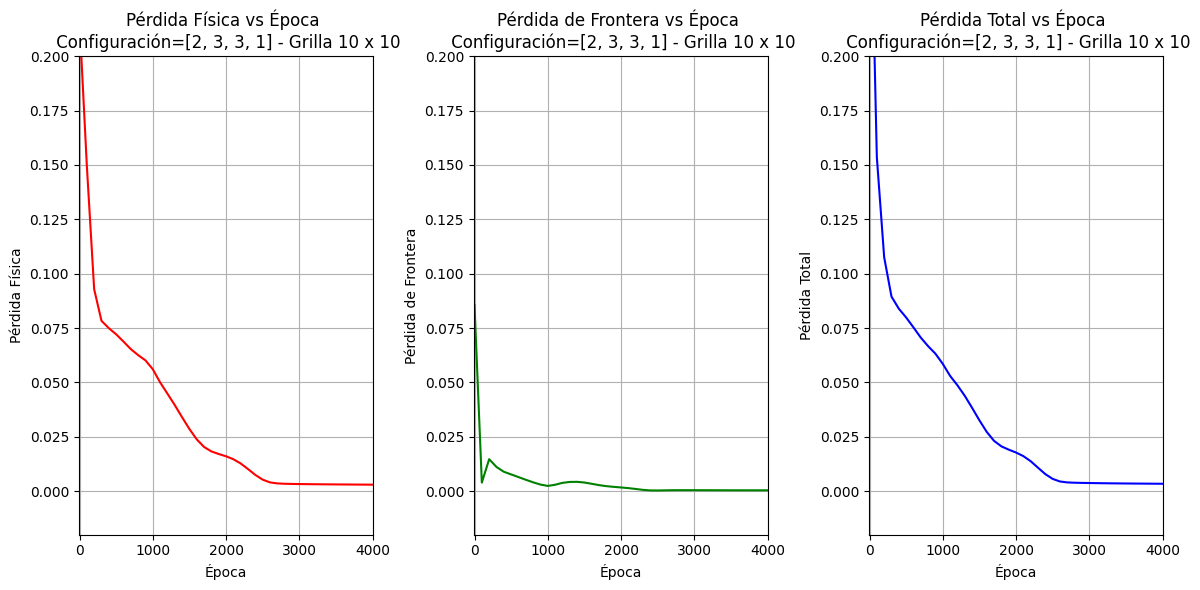

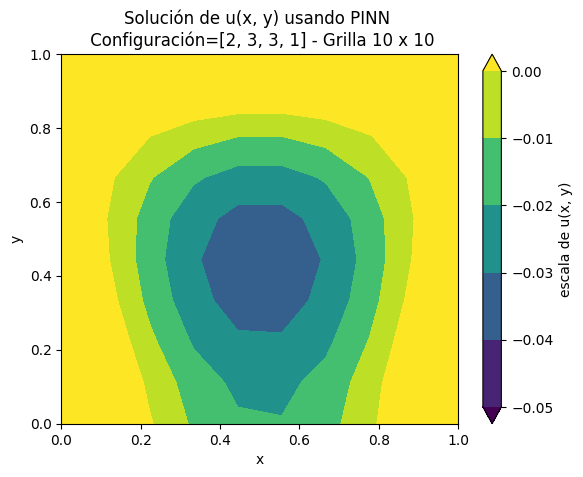

In [36]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_10x10, y_10x10, u_pred_10x10, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

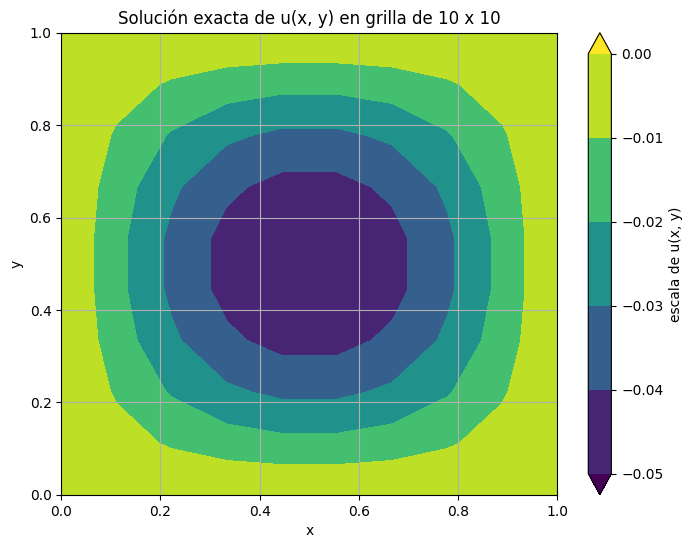

In [37]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_10x10, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

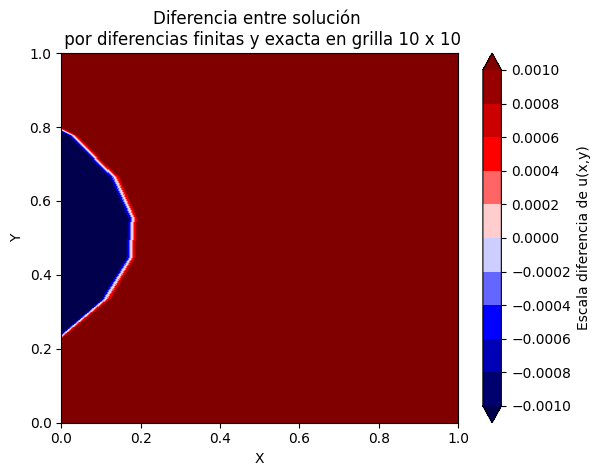

In [38]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_10x10, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.45081621408462524
Epoch 100, Loss: 0.24157041311264038
Epoch 200, Loss: 0.15663380920886993
Epoch 300, Loss: 0.09082482755184174
Epoch 400, Loss: 0.07088873535394669
Epoch 500, Loss: 0.06717504560947418
Epoch 600, Loss: 0.06388799101114273
Epoch 700, Loss: 0.059143587946891785
Epoch 800, Loss: 0.05438767373561859
Epoch 900, Loss: 0.05129048228263855
Epoch 1000, Loss: 0.04916257783770561
Epoch 1100, Loss: 0.046832721680402756
Epoch 1200, Loss: 0.04319246485829353
Epoch 1300, Loss: 0.03661201894283295
Epoch 1400, Loss: 0.026479749009013176
Epoch 1500, Loss: 0.0189431831240654
Epoch 1600, Loss: 0.01562195923179388
Epoch 1700, Loss: 0.013930105604231358
Epoch 1800, Loss: 0.012797418981790543
Epoch 1900, Loss: 0.011873460374772549
Epoch 2000, Loss: 0.011058247648179531
Epoch 2100, Loss: 0.010340215638279915
Epoch 2200, Loss: 0.009726514108479023
Epoch 2300, Loss: 0.009201127104461193
Epoch 2400, Loss: 0.00872513186186552
Epoch 2500, Loss: 0.008255627006292343
Epoch 2600, Lo

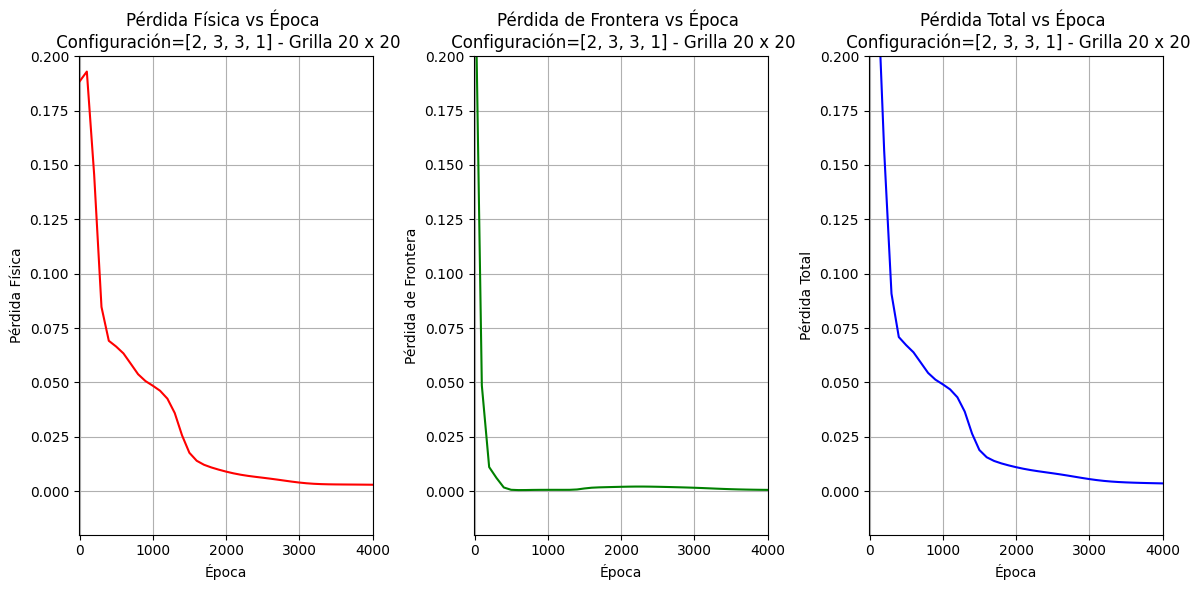

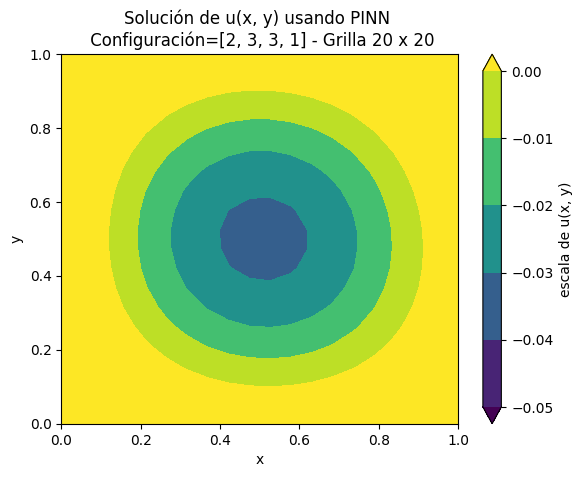

In [39]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

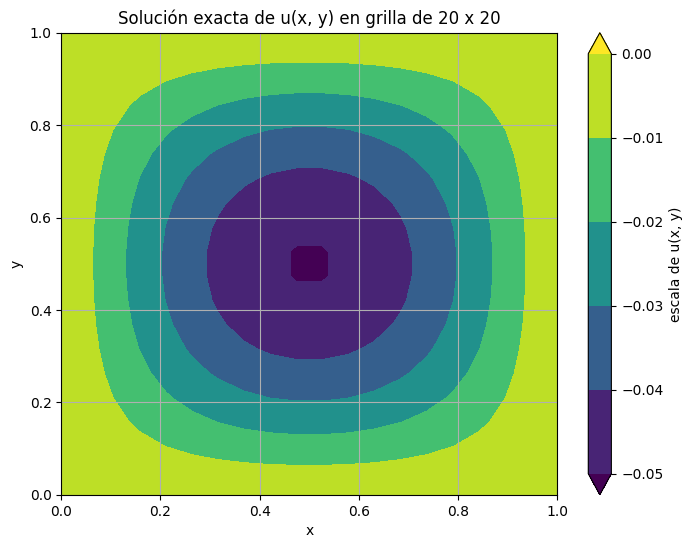

In [40]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

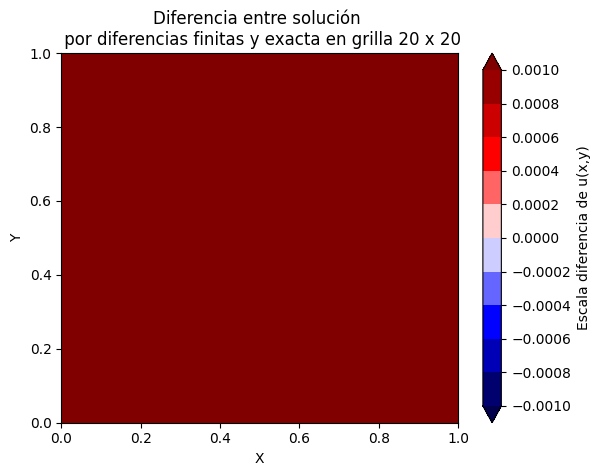

In [41]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

## B - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1]

### I - Grilla de 5 x 5:

Epoch 0, Loss: 0.3842637538909912
Epoch 100, Loss: 0.14859043061733246
Epoch 200, Loss: 0.10374358296394348
Epoch 300, Loss: 0.0824710875749588
Epoch 400, Loss: 0.07577193528413773
Epoch 500, Loss: 0.07213210314512253
Epoch 600, Loss: 0.07038076221942902
Epoch 700, Loss: 0.06902240961790085
Epoch 800, Loss: 0.06725417822599411
Epoch 900, Loss: 0.06335213035345078
Epoch 1000, Loss: 0.04824180528521538
Epoch 1100, Loss: 0.022401578724384308
Epoch 1200, Loss: 0.00945918820798397
Epoch 1300, Loss: 0.005461875349283218
Epoch 1400, Loss: 0.004925621207803488
Epoch 1500, Loss: 0.004659547004848719
Epoch 1600, Loss: 0.004439374431967735
Epoch 1700, Loss: 0.004243241623044014
Epoch 1800, Loss: 0.004062867257744074
Epoch 1900, Loss: 0.0038932606112211943
Epoch 2000, Loss: 0.0037311555352061987
Epoch 2100, Loss: 0.003574435831978917
Epoch 2200, Loss: 0.0034217070788145065
Epoch 2300, Loss: 0.003272020723670721
Epoch 2400, Loss: 0.00312471529468894
Epoch 2500, Loss: 0.0029793730936944485
Epoch 260

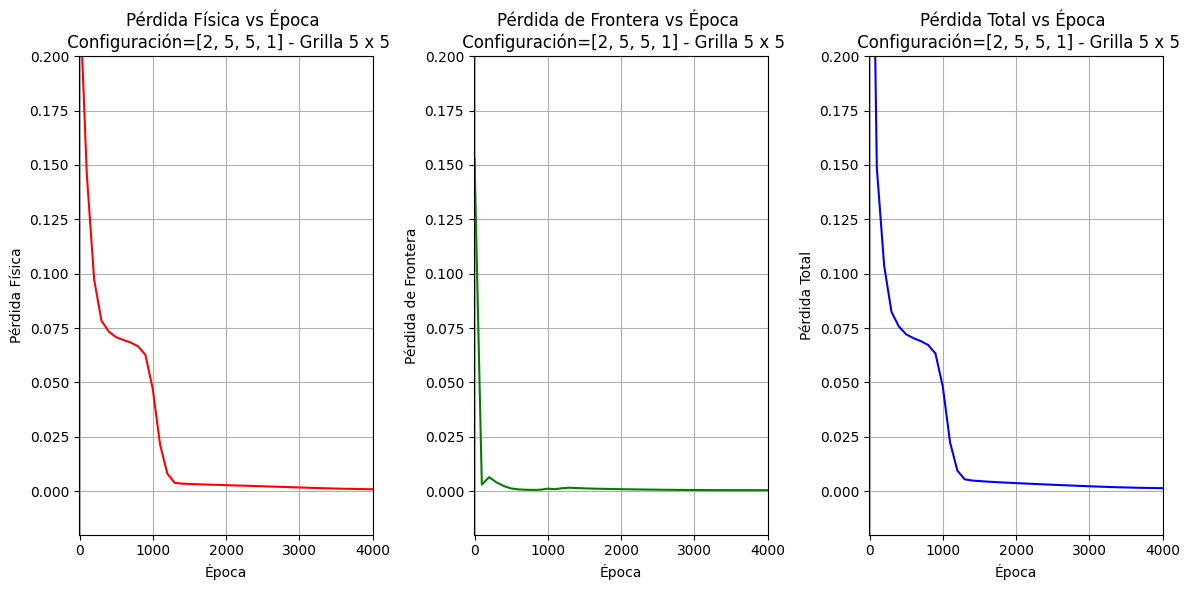

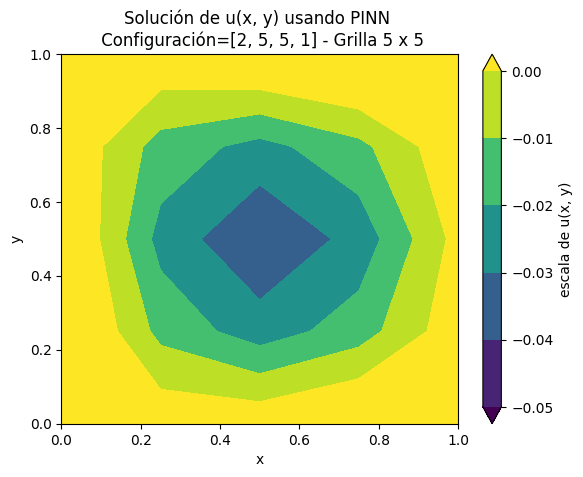

In [46]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_5x5, y_5x5, u_pred_5x5, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

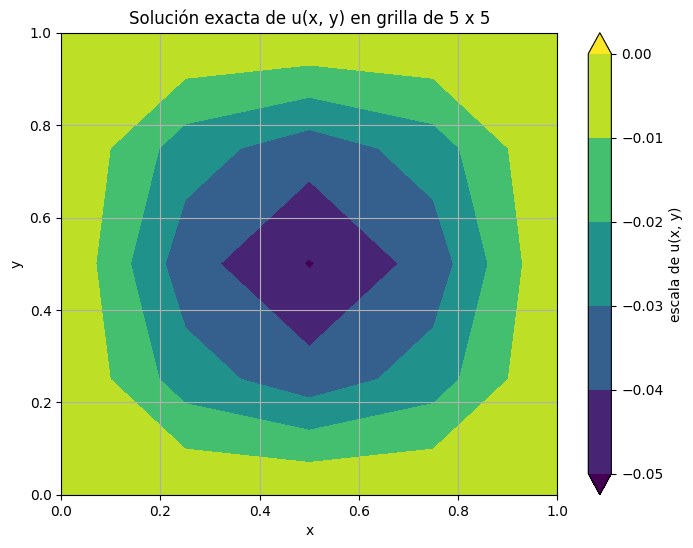

In [47]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_5x5, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

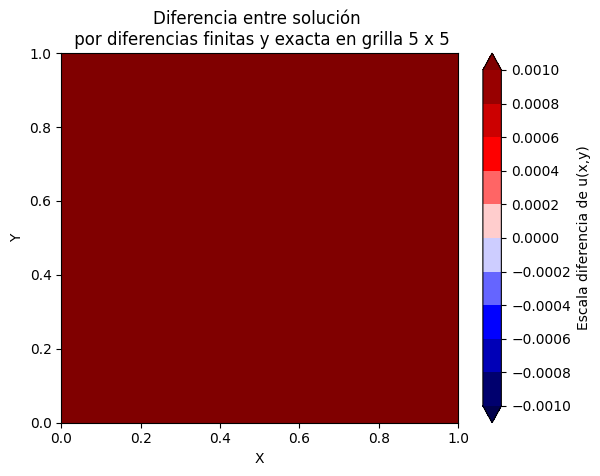

In [48]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_5x5, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.3303045630455017
Epoch 100, Loss: 0.11835851520299911
Epoch 200, Loss: 0.08637543022632599
Epoch 300, Loss: 0.07975979894399643
Epoch 400, Loss: 0.07382641732692719
Epoch 500, Loss: 0.06904962658882141
Epoch 600, Loss: 0.06514623761177063
Epoch 700, Loss: 0.061240650713443756
Epoch 800, Loss: 0.05686257779598236
Epoch 900, Loss: 0.051402267068624496
Epoch 1000, Loss: 0.04410387575626373
Epoch 1100, Loss: 0.03524014353752136
Epoch 1200, Loss: 0.02670210227370262
Epoch 1300, Loss: 0.01884200982749462
Epoch 1400, Loss: 0.011826304718852043
Epoch 1500, Loss: 0.006435399409383535
Epoch 1600, Loss: 0.004279355052858591
Epoch 1700, Loss: 0.003511189017444849
Epoch 1800, Loss: 0.00313110020942986
Epoch 1900, Loss: 0.0028993349988013506
Epoch 2000, Loss: 0.0027337989304214716
Epoch 2100, Loss: 0.0025987501721829176
Epoch 2200, Loss: 0.002476789988577366
Epoch 2300, Loss: 0.0023594731464982033
Epoch 2400, Loss: 0.0022432024125009775
Epoch 2500, Loss: 0.0021270266734063625
Epoch 

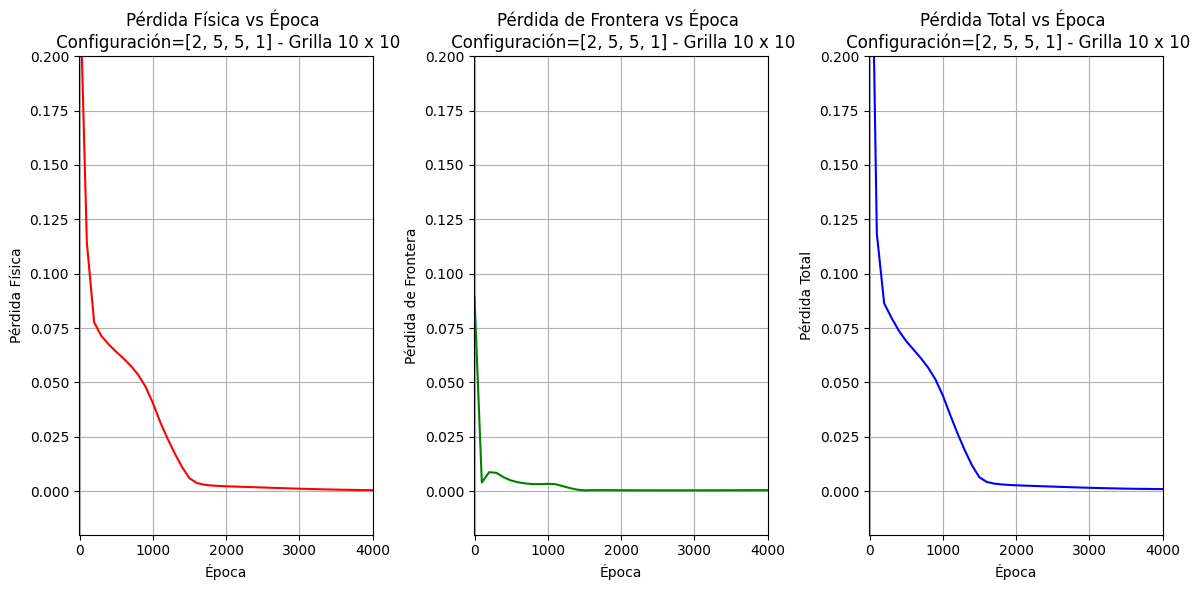

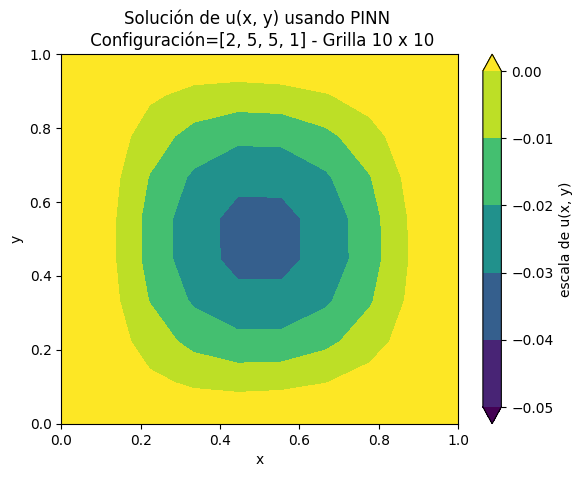

In [49]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_10x10, y_10x10, u_pred_10x10, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

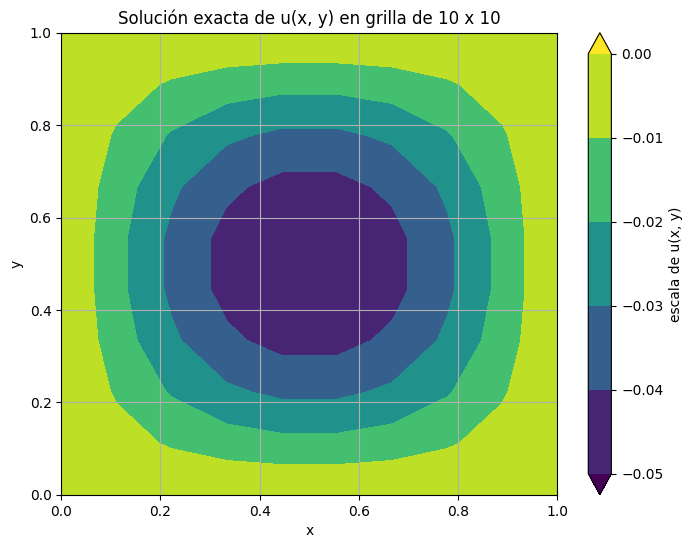

In [50]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_10x10, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

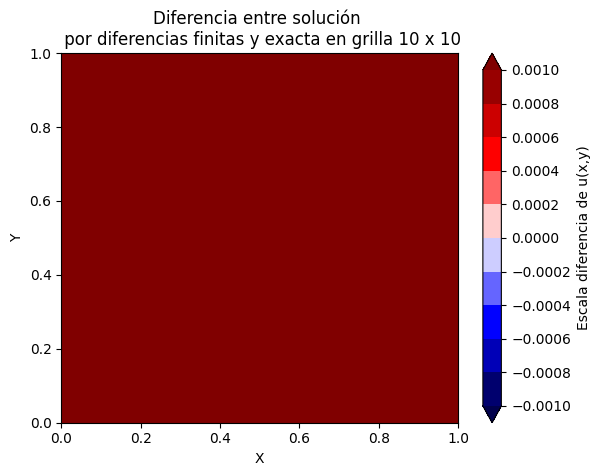

In [51]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_10x10, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.15566228330135345
Epoch 100, Loss: 0.07459171861410141
Epoch 200, Loss: 0.06022985279560089
Epoch 300, Loss: 0.043029893189668655
Epoch 400, Loss: 0.02856375090777874
Epoch 500, Loss: 0.009282300248742104
Epoch 600, Loss: 0.006374887190759182
Epoch 700, Loss: 0.004712418653070927
Epoch 800, Loss: 0.0036047117318958044
Epoch 900, Loss: 0.0028822727035731077
Epoch 1000, Loss: 0.0024034585803747177
Epoch 1100, Loss: 0.0020596280228346586
Epoch 1200, Loss: 0.00179155427031219
Epoch 1300, Loss: 0.0015733992913737893
Epoch 1400, Loss: 0.0013941284269094467
Epoch 1500, Loss: 0.0012453364906832576
Epoch 1600, Loss: 0.001119042281061411
Epoch 1700, Loss: 0.0010104796383529902
Epoch 1800, Loss: 0.0009182723588310182
Epoch 1900, Loss: 0.0008418780053034425
Epoch 2000, Loss: 0.0007795719429850578
Epoch 2100, Loss: 0.000728498212993145
Epoch 2200, Loss: 0.0006857506232336164
Epoch 2300, Loss: 0.0006490706582553685
Epoch 2400, Loss: 0.000616914767306298
Epoch 2500, Loss: 0.000588280

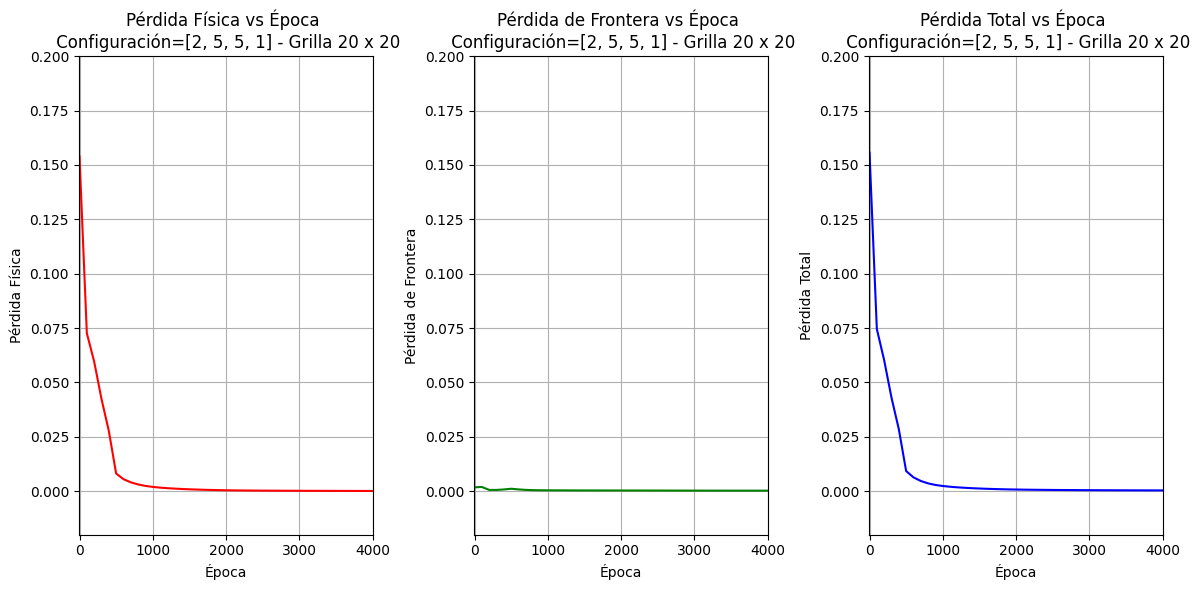

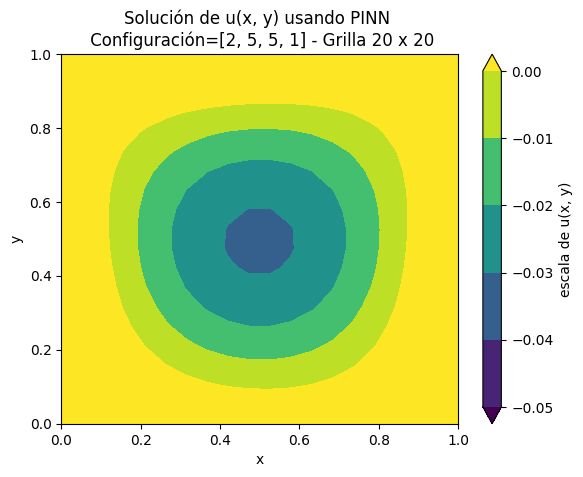

In [52]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

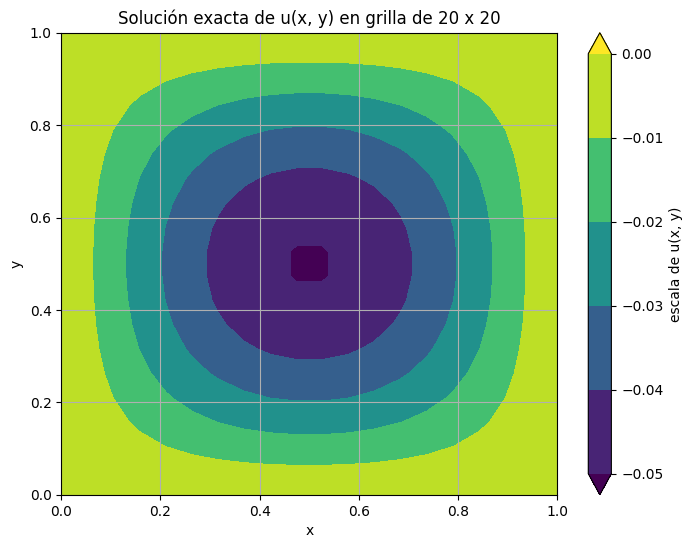

In [53]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferenicia

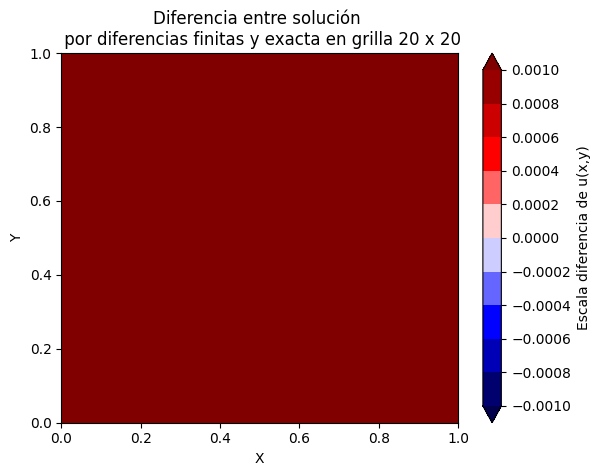

In [54]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

## C - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,10,10,1]

### I - Grilla de 5 x 5:

Epoch 0, Loss: 0.20482388138771057
Epoch 100, Loss: 0.08301910758018494
Epoch 200, Loss: 0.055626071989536285
Epoch 300, Loss: 0.035748619586229324
Epoch 400, Loss: 0.008664101362228394
Epoch 500, Loss: 0.0038768488448113203
Epoch 600, Loss: 0.002224138705059886
Epoch 700, Loss: 0.0016116425395011902
Epoch 800, Loss: 0.0013056803727522492
Epoch 900, Loss: 0.0011138067347928882
Epoch 1000, Loss: 0.0009713912731967866
Epoch 1100, Loss: 0.0008570194477215409
Epoch 1200, Loss: 0.0007621613331139088
Epoch 1300, Loss: 0.0006824451265856624
Epoch 1400, Loss: 0.0006150557310320437
Epoch 1500, Loss: 0.0005578523268923163
Epoch 1600, Loss: 0.0005091425846330822
Epoch 1700, Loss: 0.0004676463140640408
Epoch 1800, Loss: 0.00043246999848634005
Epoch 1900, Loss: 0.00040297844680026174
Epoch 2000, Loss: 0.0003786442393902689
Epoch 2100, Loss: 0.0003588928666431457
Epoch 2200, Loss: 0.0003430485085118562
Epoch 2300, Loss: 0.00033037731191143394
Epoch 2400, Loss: 0.0003201871004421264
Epoch 2500, Loss:

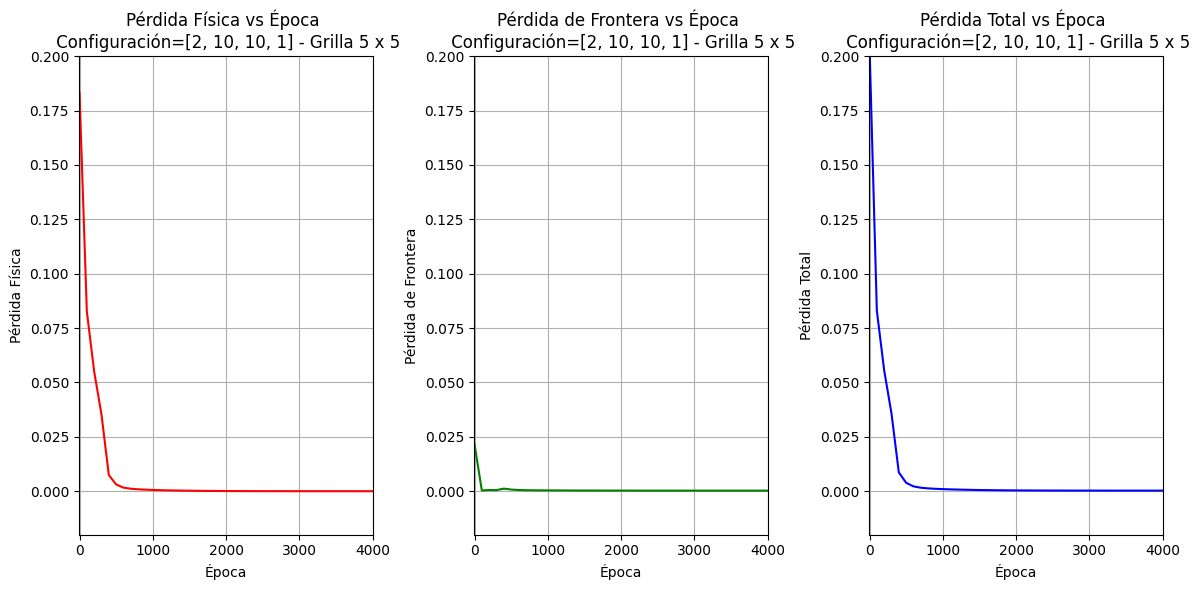

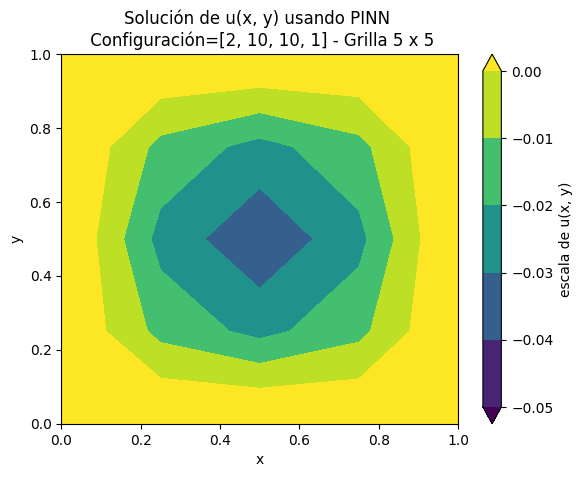

In [56]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_5x5, y_5x5, u_pred_5x5, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

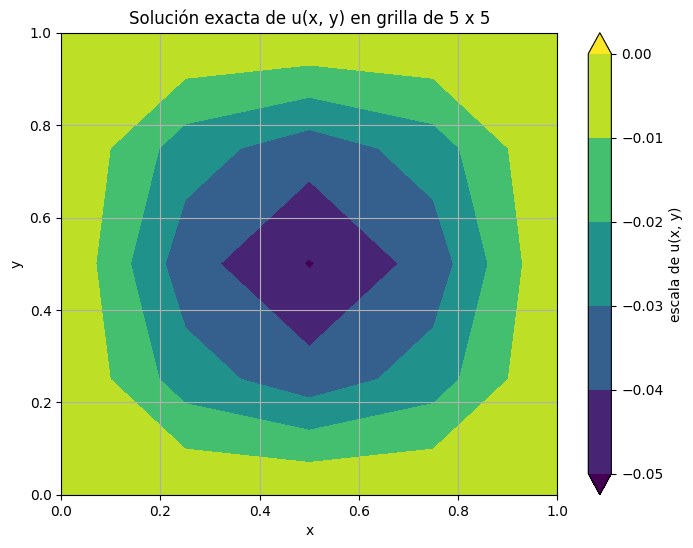

In [57]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_5x5, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

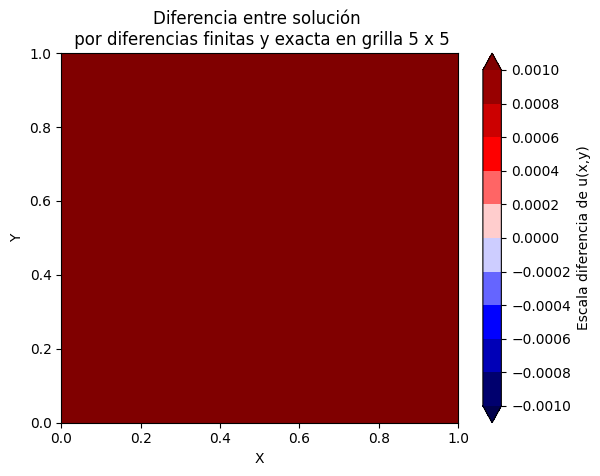

In [58]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_5x5, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.2585112154483795
Epoch 100, Loss: 0.09114328771829605
Epoch 200, Loss: 0.07353416085243225
Epoch 300, Loss: 0.04588848724961281
Epoch 400, Loss: 0.009749864228069782
Epoch 500, Loss: 0.006951677612960339
Epoch 600, Loss: 0.005678032990545034
Epoch 700, Loss: 0.004529892932623625
Epoch 800, Loss: 0.003377289045602083
Epoch 900, Loss: 0.0024585591163486242
Epoch 1000, Loss: 0.0019196016946807504
Epoch 1100, Loss: 0.0015830681659281254
Epoch 1200, Loss: 0.0013603949919342995
Epoch 1300, Loss: 0.001196491182781756
Epoch 1400, Loss: 0.0010672574862837791
Epoch 1500, Loss: 0.0009665153338573873
Epoch 1600, Loss: 0.0008909816388040781
Epoch 1700, Loss: 0.0008326428942382336
Epoch 1800, Loss: 0.0007838571327738464
Epoch 1900, Loss: 0.0007411782862618566
Epoch 2000, Loss: 0.0007031853310763836
Epoch 2100, Loss: 0.0006688639987260103
Epoch 2200, Loss: 0.0006373280193656683
Epoch 2300, Loss: 0.0006078890291973948
Epoch 2400, Loss: 0.0005800595972687006
Epoch 2500, Loss: 0.0005535

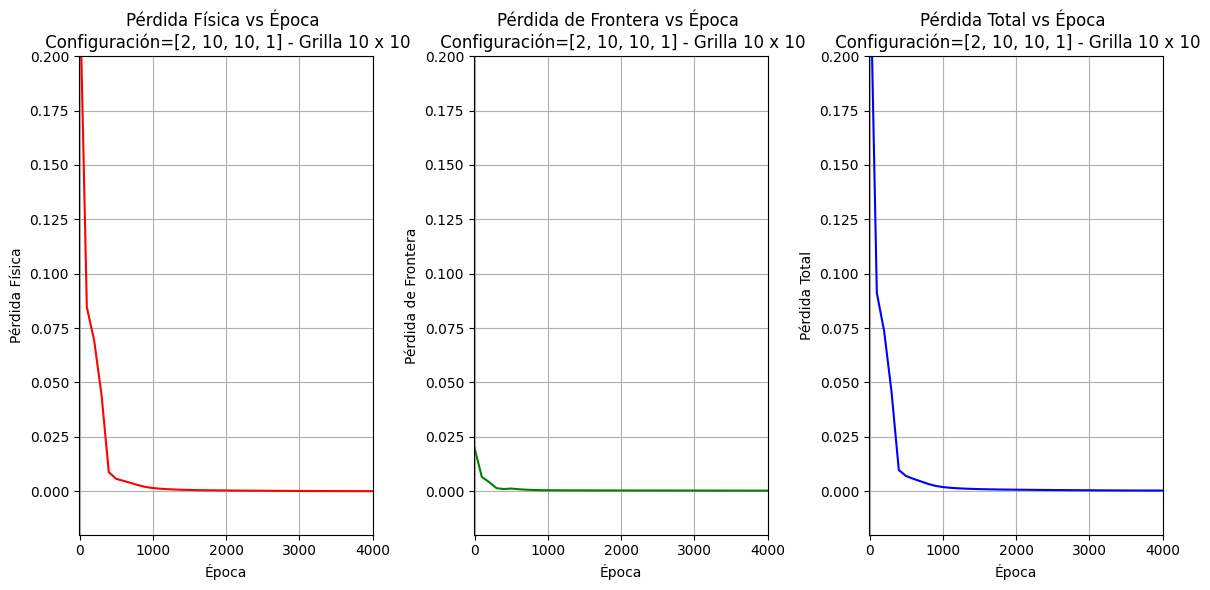

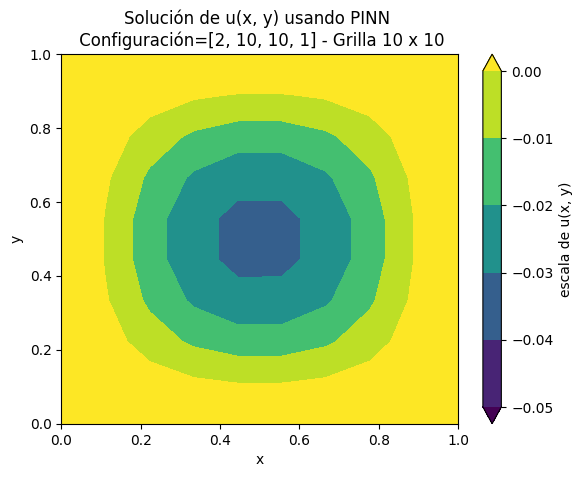

In [59]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_10x10, y_10x10, u_pred_10x10, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

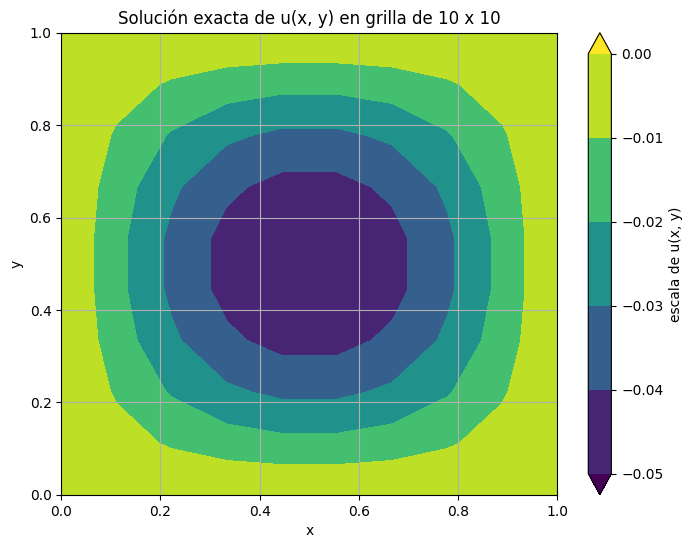

In [60]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_10x10, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

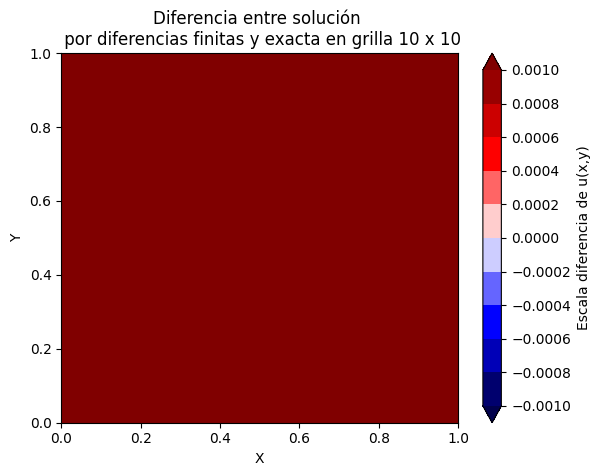

In [61]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_10x10, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.2832976281642914
Epoch 100, Loss: 0.07973852008581161
Epoch 200, Loss: 0.05932808294892311
Epoch 300, Loss: 0.045034028589725494
Epoch 400, Loss: 0.02715228497982025
Epoch 500, Loss: 0.00790041871368885
Epoch 600, Loss: 0.004832765087485313
Epoch 700, Loss: 0.003738006576895714
Epoch 800, Loss: 0.002735729794949293
Epoch 900, Loss: 0.0019324549939483404
Epoch 1000, Loss: 0.0015107376966625452
Epoch 1100, Loss: 0.0013087718980386853
Epoch 1200, Loss: 0.0011871425667777658
Epoch 1300, Loss: 0.001096702879294753
Epoch 1400, Loss: 0.0010217784438282251
Epoch 1500, Loss: 0.0009565280633978546
Epoch 1600, Loss: 0.0008984516025520861
Epoch 1700, Loss: 0.000846425537019968
Epoch 1800, Loss: 0.0007998733199201524
Epoch 1900, Loss: 0.0007583489641547203
Epoch 2000, Loss: 0.0007213476346805692
Epoch 2100, Loss: 0.0006882749730721116
Epoch 2200, Loss: 0.0006585043738596141
Epoch 2300, Loss: 0.0006314456695690751
Epoch 2400, Loss: 0.0006065951893106103
Epoch 2500, Loss: 0.000583550

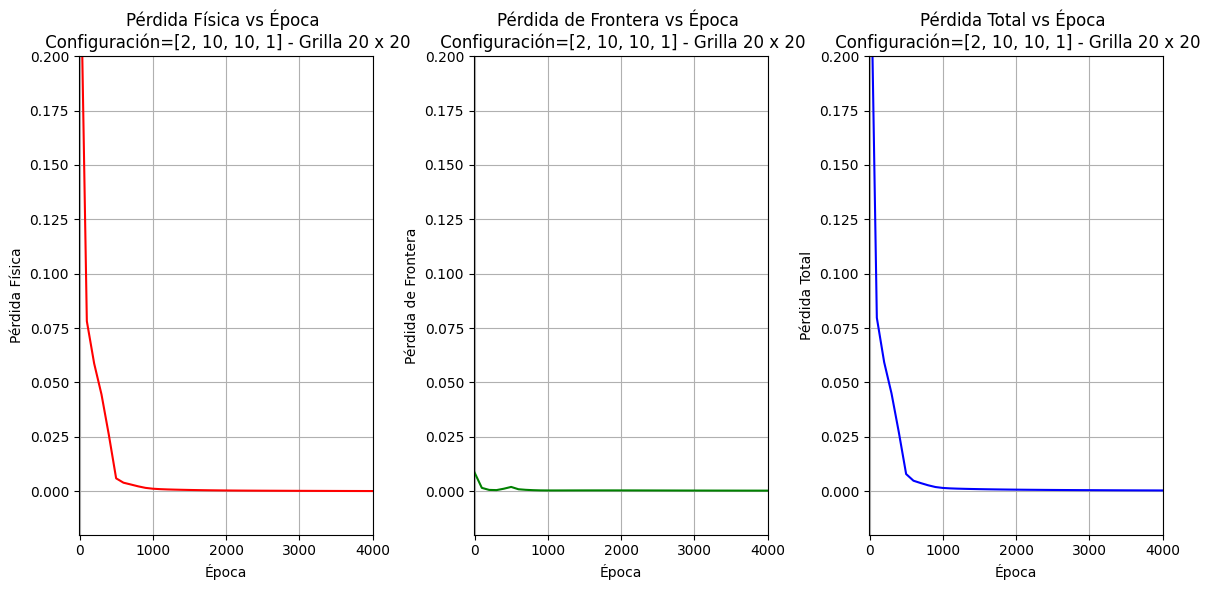

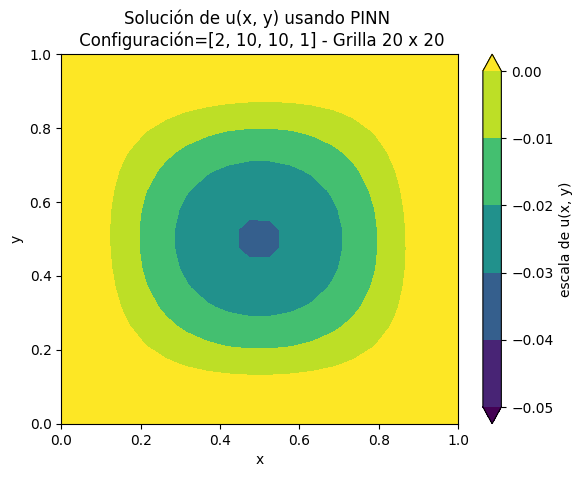

In [62]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

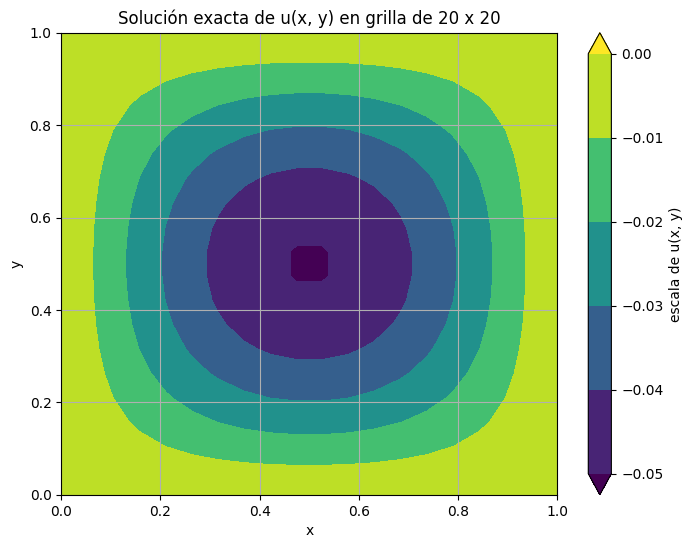

In [63]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

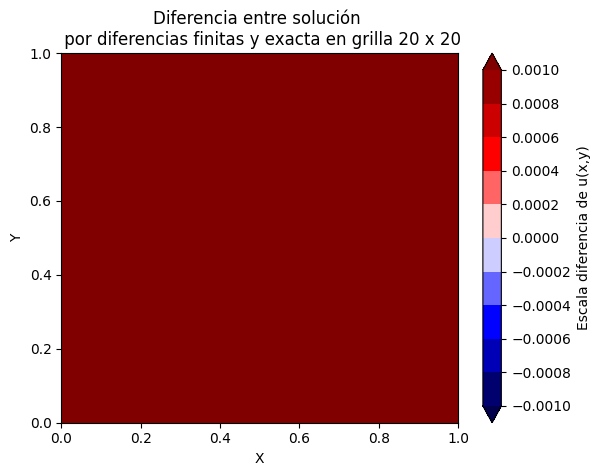

In [64]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20